# Handwriting Recognition
From image to characeters

In [24]:
import json
import multiprocessing
import os
import random
import string
import time

import matplotlib.pyplot as plt
from mxboard import SummaryWriter
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon.model_zoo.vision import resnet34_v1
import numpy as np
from skimage import transform as skimage_tf
from skimage import exposure
from tqdm import tqdm
np.seterr(all='raise')

mx.random.seed(1)

from ocr.utils.iam_dataset import IAMDataset
from ocr.utils.draw_text_on_image import draw_text_on_image

alphabet_encoding = r' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet_dict = {alphabet_encoding[i]:i for i in range(len(alphabet_encoding))}

## Network definition
Define a CNN-biLSTM for handwriting recognition.
Image features at two levels were obtained from a truncated Resnet34 and downsampled with a simple CNN. 
The 2 sets of image features were fed into two separate biLSTM for handwriting recognition. 

In [3]:
class EncoderLayer(gluon.HybridBlock):
    '''
    The encoder layer takes the image features from a CNN. The image features are transposed so that the LSTM 
    slices of the image features can be sequentially fed into the LSTM from left to right (and back via the
    bidirectional LSTM). 
    '''
    def __init__(self, hidden_states=200, rnn_layers=1, max_seq_len=100, **kwargs):
        self.max_seq_len = max_seq_len
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(hidden_states, rnn_layers, bidirectional=True)
            
    def hybrid_forward(self, F, x):
        x = x.transpose((0, 3, 1, 2))
        x = x.flatten()
        x = x.split(num_outputs=self.max_seq_len, axis=1) # (SEQ_LEN, N, CHANNELS)
        x = F.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) #(N, SEQ_LEN, HIDDEN_UNITS)
        return x

class CNNBiLSTM(gluon.HybridBlock):
    '''
    The CNN-biLSTM to recognise handwriting text given an image of handwriten text.
    Parameters
    ----------
    num_downsamples: int, default 2
        The number of times to downsample the image features. Each time the features are downsampled, a new LSTM
        is created. 
    resnet_layer_id: int, default 4
        The layer ID to obtain features from the resnet34
    lstm_hidden_states: int, default 200
        The number of hidden states used in the LSTMs
    lstm_layers: int, default 1
        The number of layers of LSTMs to use
    '''
    FEATURE_EXTRACTOR_FILTER = 64
    def __init__(self, num_downsamples=2, resnet_layer_id=4, rnn_hidden_states=200, rnn_layers=1, max_seq_len=100, ctx=mx.gpu(0), **kwargs):
        super(CNNBiLSTM, self).__init__(**kwargs)
        self.p_dropout = 0.5
        self.num_downsamples = num_downsamples
        self.max_seq_len = max_seq_len
        self.ctx = ctx
        with self.name_scope():
            self.body = self.get_body(resnet_layer_id=resnet_layer_id)

            self.encoders = gluon.nn.HybridSequential()
            with self.encoders.name_scope():
                for i in range(self.num_downsamples):
                    encoder = self.get_encoder(rnn_hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len)
                    self.encoders.add(encoder)
            self.decoder = self.get_decoder()
            self.downsampler = self.get_down_sampler(self.FEATURE_EXTRACTOR_FILTER)

    def get_down_sampler(self, num_filters):
        '''
        Creates a two-stacked Conv-BatchNorm-Relu and then a pooling layer to
        downsample the image features by half.
        
        Parameters
        ----------
        num_filters: int
            To select the number of filters in used the downsampling convolutional layer.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The downsampler network that decreases the width and height of the image features by half.
        
        '''
        out = gluon.nn.HybridSequential()
        with out.name_scope():
            for _ in range(2):
                out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
                out.add(gluon.nn.BatchNorm(in_channels=num_filters))
                out.add(gluon.nn.Activation('relu'))
            out.add(gluon.nn.MaxPool2D(2))
            out.collect_params().initialize(mx.init.Normal(), ctx=self.ctx)
        out.hybridize()
        return out

    def get_body(self, resnet_layer_id):
        '''
        Create the feature extraction network based on resnet34.
        The first layer of the res-net is converted into grayscale by averaging the weights of the 3 channels
        of the original resnet.
        
        Parameters
        ----------
        resnet_layer_id: int
            The resnet_layer_id specifies which layer to take from 
            the bottom of the network.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The body network for feature extraction based on resnet
        '''
        
        pretrained = resnet34_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Xavier(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-resnet_layer_id])
        return body

    def get_encoder(self, rnn_hidden_states, rnn_layers, max_seq_len):
        '''
        Creates an LSTM to learn the sequential component of the image features.
        
        Parameters
        ----------
        
        rnn_hidden_states: int
            The number of hidden states in the RNN
        
        rnn_layers: int
            The number of layers to stack the RNN
        Returns
        -------
        
        network: gluon.nn.Sequential
            The encoder network to learn the sequential information of the image features
        '''

        encoder = gluon.nn.HybridSequential()
        with encoder.name_scope():
            encoder.add(EncoderLayer(hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len))
            encoder.add(gluon.nn.Dropout(self.p_dropout))
        encoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return encoder
    
    def get_decoder(self):
        '''
        Creates a network to convert the output of the encoder into characters.
        '''

        alphabet_size = len(alphabet_encoding) + 1
        decoder = mx.gluon.nn.Dense(units=alphabet_size, flatten=False)
        decoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return decoder

    def hybrid_forward(self, F, x):
        features = self.body(x)
        hidden_states = []
        hs = self.encoders[0](features)
        hidden_states.append(hs)
        for i, _ in enumerate(range(self.num_downsamples - 1)):
            features = self.downsampler(features)
            hs = self.encoders[i+1](features)
            hidden_states.append(hs)
        hs = F.concat(*hidden_states, dim=2)
        output = self.decoder(hs)
        return output

### Helper functions to train the network 

In [4]:
def transform(image, label):
    '''
    This function resizes the input image and converts so that it could be fed into the network.
    Furthermore, the label (text) is one-hot encoded.
    '''
    image = np.expand_dims(image, axis=0).astype(np.float32)
    if image[0, 0, 0] > 1:
        image = image/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    label_encoded = np.zeros(max_seq_len, dtype=np.float32)-1
    i = 0
    for word in label:
        word = word.replace("&quot", r'"')
        word = word.replace("&amp", r'&')
        word = word.replace('";', '\"')
        for letter in word:
            label_encoded[i] = alphabet_dict[letter]
            i += 1
    return image, label_encoded

def augment_transform(image, label):
    '''
    This function randomly:
        - translates the input image by +-width_range and +-height_range (percentage).
        - scales the image by y_scaling and x_scaling (percentage)
        - shears the image by shearing_factor (radians)
    '''
    
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)

    sx = random.uniform(1. - random_y_scaling, 1. + random_y_scaling)
    sy = random.uniform(1. - random_x_scaling, 1. + random_x_scaling)

    s = random.uniform(-random_shearing, random_shearing)
    
    gamma = random.uniform(0.001, 2)
    image = exposure.adjust_gamma(image, gamma)
    st = skimage_tf.AffineTransform(scale=(sx, sy),
                                    shear=s,
                                    translation=(tx*image.shape[1], ty*image.shape[0]))
    augmented_image = skimage_tf.warp(image, st, cval=1.0)
    
    return transform(augmented_image*255., label)


def decode(prediction):
    '''
    Returns the string given one-hot encoded vectors.
    '''

    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(alphabet_dict) or index == -1:
                continue
            else:
                result.append(alphabet_encoding[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

In [5]:
def run_epoch(e, network, dataloader, trainer, log_dir, print_name, is_train):
    total_loss = nd.zeros(1, ctx)
    for i, (x, y) in enumerate(dataloader):
        x = x.as_in_context(ctx)
        y = y.as_in_context(ctx)

        with autograd.record(train_mode=is_train):
            output = network(x)
            loss_ctc = ctc_loss(output, y)

        if is_train:
            loss_ctc.backward()
            trainer.step(x.shape[0])

        if i == 0 and e % send_image_every_n == 0 and e > 0:
            predictions = output.softmax().topk(axis=2).asnumpy()
            decoded_text = decode(predictions)
            output_image = draw_text_on_image(x.asnumpy(), decoded_text)
            output_image[output_image < 0] = 0
            output_image[output_image > 1] = 1
            print("{} first decoded text = {}".format(print_name, decoded_text[0]))
            with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
                sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)

        total_loss += loss_ctc.mean()

    epoch_loss = float(total_loss.asscalar())/len(dataloader)

    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)

    return epoch_loss

In [6]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

epochs = 120
learning_rate = 0.0001
batch_size = 32

max_seq_len = 160
print_every_n = 5
send_image_every_n = 5

num_downsamples = 2
resnet_layer_id = 4
lstm_hidden_states = 512
lstm_layers = 2

random_y_translation, random_x_translation = 0.03, 0.03
random_y_scaling, random_x_scaling = 0.1, 0.1
random_shearing = 0.7

log_dir = "./logs/handwriting_recognition"
checkpoint_dir = "model_checkpoint"
checkpoint_name = "handwriting.params"

In [7]:
train_ds = IAMDataset("line", output_data="text", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("line", output_data="text", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 7998
Number of testing samples: 1860


In [8]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, last_batch="rollover", num_workers=4)
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=True, last_batch="keep", num_workers=4)#, num_workers=multiprocessing.cpu_count()-2)

### Training

In [9]:
net = CNNBiLSTM(num_downsamples=num_downsamples, resnet_layer_id=resnet_layer_id , rnn_hidden_states=lstm_hidden_states, rnn_layers=lstm_layers, max_seq_len=max_seq_len, ctx=ctx)
net.hybridize()

In [10]:
ctc_loss = gluon.loss.CTCLoss(weight=0.2)
best_test_loss = 10e5

In [11]:
if (os.path.isfile(os.path.join(checkpoint_dir, checkpoint_name))):
    net.load_parameters(os.path.join(checkpoint_dir, checkpoint_name))
    print("Parameters loaded")
    print(run_epoch(0, net, test_data, None, log_dir, print_name="pretrained", is_train=False))

Parameters loaded
3.1196206302966103


In [11]:
pretrained = "models/handwriting_line8.params"
if (os.path.isfile(pretrained)):
    net.load_parameters(pretrained, ctx=ctx)
    print("Parameters loaded")
    print(run_epoch(0, net, test_data, None, log_dir, print_name="pretrained", is_train=False))

Parameters loaded
3.1373743606826006


In [158]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

In [ ]:
for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, trainer, log_dir, print_name="train", is_train=True)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", is_train=False)    
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(checkpoint_dir, checkpoint_name))
        best_test_loss = test_loss
        
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

# Results
Visually inspect the results of the test dataset

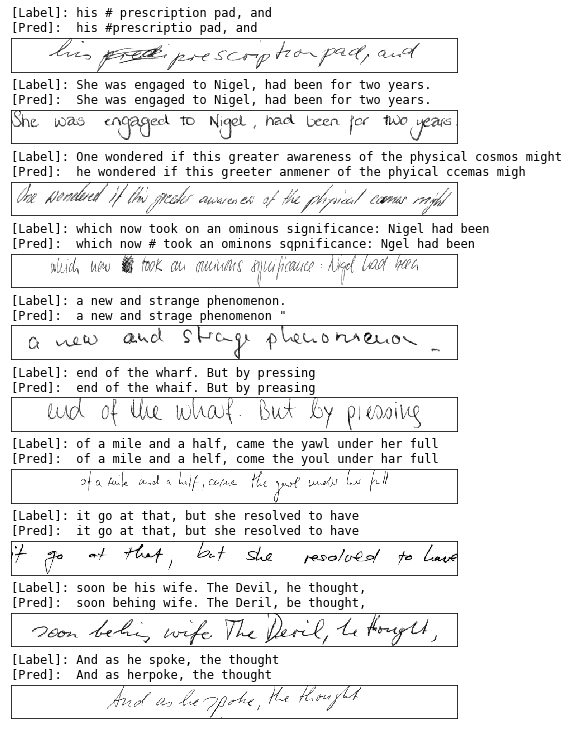

In [20]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, figsize=(8, 1.3*figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, actual_label = test_ds[n]
    image, _ = transform(image, actual_label)

    image = nd.array(image)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    output = net(image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decode(predictions)[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')
    axs[i].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    axs[i].set_title("[Label]: {}\n[Pred]:  {}".format(actual_label[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"'), decoded_prediction_text),
                    fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
    axs[i].tick_params(axis='both',       
                       which='both',      
                       bottom=False,      
                       top=False,         
                       left=False,
                       right=False,
                       labelleft=False,
                       labelbottom=False) 


## Writing the transformed test dataset for validating the language denoiser

In [21]:
ds_lm = test_ds.transform(transform)

In [22]:
outputs = []
for image, actual_label in tqdm(ds_lm):
    image = nd.array(image)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    output = net(image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decode(predictions)[0]
    outputs.append([decode([actual_label])[0].replace("&quot;", '"').replace("&amp;", "&"), decoded_prediction_text.replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')])

100%|██████████| 1860/1860 [01:08<00:00, 27.23it/s]


In [25]:
json.dump(outputs, open('dataset/typo/validating.json', 'w'))

In [31]:
ds_lm = train_ds
with open('dataset/typo/text_train.txt', 'w') as f:
    for _, actual_label in ds_lm:
        f.write(str(actual_label[0].replace("&quot;", '"').replace("&amp;", "&"))+"\n")